In [7]:
import os
import cv2
import numpy as np
from skimage import exposure


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and (filename.endswith('.jpeg') or filename.endswith('.png')):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize image to 64x64
                img = cv2.resize(img, (64, 64))
                flattened_img = img.flatten()
                images.append(flattened_img)
    return images

# Folder paths
sad_folder = "frown_imgs/frowning"
neutral_folder = "frown_imgs/normal"
# test_sad_folder = "fer2013/test/sad"
# test_neutral_folder ="fer2013/test/neutral"
# test_happy_folder = "fer2013/test/happy"
# sad2_folder = "emotion/sadness"
# angry2_folder = "emotion/anger"
# happy2_folder = "emotion/happiness"


# Load images from folders
sad_images = load_images_from_folder(sad_folder)
neutral_images = load_images_from_folder(neutral_folder)
# happy_images = load_images_from_folder(happy_folder)
# test_sad_images = load_images_from_folder(test_sad_folder)
# test_neutral_images = load_images_from_folder(test_neutral_folder)
# test_happy_images = load_images_from_folder(test_happy_folder)
# sad2_images = load_images_from_folder(sad2_folder)
# angry2_images = load_images_from_folder(angry2_folder)
# happy2_images = load_images_from_folder(happy2_folder)



# Convert images to numpy arrays
sad_data = np.array(sad_images)
neutral_data = np.array(neutral_images)
# happy_data = np.array(happy_images)
# test_sad_data = np.array(test_sad_images)
# test_neutral_data = np.array(test_neutral_images)
# test_happy_data = np.array(test_happy_images)
# sad2_data = np.array(sad2_images)
# angry2_data = np.array(angry2_images)
# happy2_data = np.array(happy2_images)

print(np.shape(sad_images))

(31, 4096)


In [8]:
mouth_cascade_path = '/Users/henrythomas/Desktop/ECE420/Final_Project/haarcascade_mouth.xml'
mouth_cascade = cv2.CascadeClassifier(mouth_cascade_path)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


def process_image_2(image_array, target_size=(64, 64)):
    # Convert the 1D array to 2D array (64x64 image)
    image = np.reshape(image_array, (64, 64))

    # Convert the image to uint8 for OpenCV
    image_uint8 = np.uint8(image)
    
    lower_half_face = image_uint8[64*5//8:64, 64//6:64-64//6]
    Y = 64*5//8
    X = 64//6
    H = 64 - Y
    W = 64 - 2*X

    # Detect mouths in the image
    mouths = mouth_cascade.detectMultiScale(lower_half_face, scaleFactor=1.01, minNeighbors=3, minSize=(10, 10))

    # If at least one mouth is detected, process the first one
    if len(mouths) > 0:
        (x, y, w, h) = mouths[0]  # Get the coordinates of the first mouth

        # Crop the mouth
        mouth = lower_half_face[y:y + h, x:x + w]

        # Resize the mouth to the target size
        resized_mouth = cv2.resize(mouth, target_size)

        # Flatten the 2D resized mouth to 1D array
        return resized_mouth.flatten()

    # If no mouth is detected, return None
    return None

def process_image_4(image_array, target_size=(64, 64)):
    # Convert the 1D array to 2D array (64x64 image)
    image = np.reshape(image_array, (64, 64))

    # Convert the image to uint8 for OpenCV
    image_uint8 = np.uint8(image)
        
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(image_uint8, scaleFactor=1.2, minNeighbors=1, minSize=(20,20))
    
    # If at least one face is detected, process the first one
    if len(faces) > 0:
        (x, y, w, h) = faces[0]  # Get the coordinates of the first face

        # Crop the face region
        face_roi = image_uint8[y:y + h, x:x + w]

        # Resize the face to the target size
        resized_face = cv2.resize(face_roi, target_size)

        # Flatten the 2D resized face to 1D array
        return resized_face.flatten()

    # If no face is detected, return None
    return None


def normalize_image(image):
    # Reshape image to 2D array of size (64, 64)
    image_2d = np.reshape(image, (64, 64))
    
    # Equalize histogram to improve contrast
    equalized = cv2.equalizeHist(image_2d.astype(np.uint8))
    
    # Flatten image
    flattened = equalized.flatten()
    
    return flattened


def find_mouth_norm(images_array):
    ret_img = []
    non_norm = []
    for i in range(np.shape(images_array)[0]):
        image = process_image_2(images_array[i])
        if image is not None:
            non_norm.append(image)
            normalized_image = normalize_image(image)
            ret_img.append(normalized_image)
    # Convert the list of detected faces to a NumPy array
    print(np.shape(ret_img))
    ret_img = np.array(ret_img, dtype=np.int8)
    return ret_img, non_norm

def move_ave(queue, inp):
    queue.pop(0)
    queue.append(inp)
    return np.mean(queue)


In [9]:
import os
import cv2
import numpy as np
from skimage import exposure

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def trainPerceptron_2(train_set, train_labels,learning_rate, max_iter):
    input_size = train_set.shape[1]
    hidden_size = 16  # Number of neurons in the hidden layer
    
    # Initialize weights and biases for the hidden layer
    W1 = np.random.randn(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    
    # Initialize weights and biases for the output layer
    W2 = np.random.randn(hidden_size)
    b2 = 0
    
    for iteration in range(max_iter):
        for i, image in enumerate(train_set):
            # Forward propagation
            hidden_output = sigmoid(np.dot(image, W1) + b1)
            output = sigmoid(np.dot(hidden_output, W2) + b2)
            
            # Backpropagation
            output_error = train_labels[i] - output
            hidden_error = output_error * sigmoid_derivative(output) * W2
            
            # Update weights and biases using gradient descent
            W2 += learning_rate * hidden_output.flatten() * output_error
            b2 += learning_rate * output_error
            W1 += learning_rate * np.outer(image, hidden_error) * sigmoid_derivative(hidden_output)
            b1 += learning_rate * hidden_error * sigmoid_derivative(hidden_output)
    
    return W1, b1, W2, b2

def classifyPerceptron_2(train_set, train_labels, dev_set, learning_rate, max_iter):
    W1, b1, W2, b2 = trainPerceptron_2(train_set, train_labels, learning_rate, max_iter)
    ret = []
    for image in dev_set:
        hidden_output = sigmoid(np.dot(image, W1) + b1)
        output = sigmoid(np.dot(hidden_output, W2) + b2)
        if output <= 0.5:
            ret.append(0)
        else:
            ret.append(1)
    return ret

def classify_smile_2(W1, b1, W2, b2, image):
    hidden_output = sigmoid(np.dot(image, W1) + b1)
    output = sigmoid(np.dot(hidden_output, W2) + b2)
    if output <= 0.5:
        return 0
    else:
        return 1
    

def trainPerceptron_4(train_set, train_labels, learning_rate, max_iter):
    input_size = train_set.shape[1]
    hidden1_size = 64  # Number of neurons in the first hidden layer
    hidden2_size = 64  # Number of neurons in the second hidden layer
    hidden3_size = 64  # Number of neurons in the third hidden layer

    # Initialize weights and biases for the first hidden layer
    W1 = np.random.randn(input_size, hidden1_size)
    b1 = np.zeros((1, hidden1_size))

    # Initialize weights and biases for the second hidden layer
    W2 = np.random.randn(hidden1_size, hidden2_size)
    b2 = np.zeros((1, hidden2_size))

    # Initialize weights and biases for the third hidden layer
    W3 = np.random.randn(hidden2_size, hidden3_size)
    b3 = np.zeros((1, hidden3_size))

    # Initialize weights and biases for the output layer
    W4 = np.random.randn(hidden3_size)
    b4 = 0
    
    for iteration in range(max_iter):
        for i, image in enumerate(train_set):
            # Forward propagation
            hidden1_output = sigmoid(np.dot(image, W1) + b1)
            hidden2_output = sigmoid(np.dot(hidden1_output, W2) + b2)
            hidden3_output = sigmoid(np.dot(hidden2_output, W3) + b3)
            output = sigmoid(np.dot(hidden3_output, W4) + b4)
            
            # Backpropagation
            output_error = train_labels[i] - output
            hidden3_error = output_error * sigmoid_derivative(output) * W4
            hidden2_error = np.dot(hidden3_error, W3.T) * sigmoid_derivative(hidden3_output)
            hidden1_error = np.dot(hidden2_error, W2.T) * sigmoid_derivative(hidden2_output)
            
            # Update weights and biases using gradient descent
            W4 += learning_rate * hidden3_output.flatten() * output_error
            b4 += learning_rate * output_error
            W3 += learning_rate * np.outer(hidden2_output, hidden3_error) * sigmoid_derivative(hidden3_output)
            b3 += learning_rate * hidden3_error * sigmoid_derivative(hidden3_output)
            W2 += learning_rate * np.outer(hidden1_output, hidden2_error) * sigmoid_derivative(hidden2_output)
            b2 += learning_rate * hidden2_error * sigmoid_derivative(hidden2_output)
            W1 += learning_rate * np.outer(image, hidden1_error) * sigmoid_derivative(hidden1_output)
            b1 += learning_rate * hidden1_error * sigmoid_derivative(hidden1_output)
    
    return W1, b1, W2, b2, W3, b3, W4, b4

def classifyPerceptron_4(train_set, train_labels, dev_set, learning_rate, max_iter):
    W1, b1, W2, b2, W3, b3, W4, b4 = trainPerceptron_4(train_set, train_labels, learning_rate, max_iter)
    ret = []
    for image in dev_set:
        hidden1_output = sigmoid(np.dot(image, W1) + b1)
        hidden2_output = sigmoid(np.dot(hidden1_output, W2) + b2)
        hidden3_output = sigmoid(np.dot(hidden2_output, W3) + b3)
        output = sigmoid(np.dot(hidden3_output, W4) + b4)
        if output <= 0.5:
            ret.append(0)
        else:
            ret.append(1)
    return ret

def classify_smile_4(W1, b1, W2, b2, W3, b3, W4, b4, image):
    hidden1_output = sigmoid(np.dot(image, W1) + b1)
    hidden2_output = sigmoid(np.dot(hidden1_output, W2) + b2)
    hidden3_output = sigmoid(np.dot(hidden2_output, W3) + b3)
    output = sigmoid(np.dot(hidden3_output, W4) + b4)
    if output <= 0.5:
        return 0
    else:
        return 1



In [13]:
sad, sad_reg = find_mouth_norm(sad_data)
neutral, neutral_reg = find_mouth_norm(neutral_data)
# happy, happy_reg = find_mouth_norm(happy_data)
# test_sad, test_sad_reg = find_mouth_norm(test_sad_data)
# test_neutral, test_neutral_reg = find_mouth_norm(test_neutral_data)
# test_happy, test_happy_reg = find_mouth_norm(test_happy_data)

test = np.concatenate((sad[0:14], neutral[0:16]))

def interleave_arrays(happy, neutral):
    interleaved = []
    min_len = min(len(happy), len(neutral))
    
    for i in range(min_len):
        interleaved.append(happy[i])
        interleaved.append(neutral[i])
    
    return interleaved

# not_sad = interleave_arrays(happy, neutral)


(14, 4096)
(25, 4096)


In [14]:
min_ = (int)(min(np.shape(sad)[0], np.shape(neutral)[0]))


train_set = np.concatenate((sad[0:min_], neutral[0:min_]))
label_set = np.concatenate((np.ones(min_), np.zeros(min_)))


classify = classifyPerceptron_2(train_set, label_set, test,.001, 10)

/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_25633/3282151775.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [15]:
print(classify)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
sad2, sad2_reg = find_mouth_norm(sad2_data)
happy2, happy2_reg = find_mouth_norm(happy2_data)
min_ = (int)(min(np.shape(sad2)[0], np.shape(happy2)[0]))
train_set = np.concatenate((sad2[0:min_], happy2[0:min_]))
label_set = np.concatenate((np.ones(min_), np.zeros(min_)))

NameError: name 'sad2_data' is not defined

In [4]:
classify = classifyPerceptron_2(train_set, label_set, test,.001, 10)


NameError: name 'train_set' is not defined

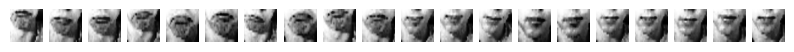

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
import matplotlib.pyplot as plt

def show_images(images, n):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(np.array(images[i].reshape(64, 64), dtype=np.uint8), cmap='gray')
        plt.axis('off')
    plt.show()
    
# show_images(smiles, 20)
# show_images(not_smiles, 20)
show_images(test, 20)
print(classify[0:10])
print(classify[10:20])

In [7]:
w1,b1,w2,b2= trainPerceptron_2(train_set, label_set, .001, 10)

/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_80201/3282151775.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [8]:
# weights, bias = trainPerceptron(train_set, label_set, 20)

q = []
q_len = 10
for i in range(q_len):
    q.append(0)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale for face and mouth detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Extract the region of interest (ROI) containing the face
        face_roi = gray[y:y+h, x:x+w]
        lower_half_face = gray[y+h*5//8:y+h, x+w//6:x+w-w//6]
#         cv2.rectangle(frame, (x+w//6, y+h*5//8), (x+w-w//6, y+h), (255, 0, 0), 2)
        X = x+w//6
        Y = y + h*5//8
        W = w - 2*w//6
        H = h - h*5//8

        # Detect mouths within the face region
        mouth = mouth_cascade.detectMultiScale(lower_half_face, scaleFactor=1.2, minNeighbors=12, minSize=(20, 20))
        
        if len(mouth) == 0:
            break
        else:
            mx, my, mw, mh = mouth[0]

            # Draw a rectangle around the detected mouth
            cv2.rectangle(frame, (X+mx, Y+my), (X+mx+mw, Y+my+mh), (0, 255, 0), 2)

            # Extract the mouth region from the face
            mouth_roi = frame[Y+my:Y+my+mh, X+mx:X+mx+mw]

            # Process the mouth image and classify smile
            gray_image = cv2.cvtColor(mouth_roi, cv2.COLOR_BGR2GRAY)
            res = cv2.resize(gray_image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
            image = normalize_image(res)
            smile_label = classify_smile_2(w1,b1,w2,b2, image)

            # Display smile label
            if move_ave(q, smile_label) < 0.5:
                cv2.putText(frame, "Happy", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            else:
                cv2.putText(frame, "Sad", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    
    # Display the frame
    cv2.imshow('Smile Detection', frame)
    
    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

2024-05-01 01:22:50.123 python[80201:5050188] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_80201/3282151775.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [18]:
# weights, bias = trainPerceptron(train_set, label_set, 20)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

q = []
q_len = 10
for i in range(q_len):
    q.append(0)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale for face and mouth detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Extract the region of interest (ROI) containing the face
        face_roi = gray[y:y+h, x:x+w]
        # Process the mouth image and classify smile
        res = cv2.resize(face_roi, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        image = normalize_image(res)
        smile_label = classify_smile_4(w1,b1,w2,b2,w3,b3,w4,b4, image)

        # Display smile label
        if move_ave(q, smile_label) < 0.5:
            cv2.putText(frame, "Happy", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        else:
            cv2.putText(frame, "Sad", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    
    # Display the frame
    cv2.imshow('Smile Detection', frame)
    
    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_25152/1063154830.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [9]:
np.savetxt('w1_frown.csv', w1, delimiter=',')
np.savetxt('b1_frown.csv', b1, delimiter=',')
np.savetxt('w2_frown.csv', w2, delimiter=',')

In [13]:
print(b2)

[-0.00025319]
